In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pillow_heif
import os

In [2]:
ranks = ['Ace', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven',
         'Eight', 'Nine', 'Ten', 'Jack', 'Queen', 'King']
suits = ['Clubs', 'Diamonds', 'Hearts', 'Spades']

RANK_WIDTH = 70
RANK_HEIGHT = 125

SUIT_WIDTH = 70
SUIT_HEIGHT = 100

In [3]:
def preprocess_image(img_path):
    """Threshold the whole image"""
    # Read image
    # image = cv2.imread(path)
    image = pillow_heif.open_heif(img_path, convert_hdr_to_8bit=False, bgr_mode=True)
    image = np.array(image)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply gaussian blur
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold the image
    _, thresh = cv2.threshold(blur, 95, 255, cv2.THRESH_BINARY_INV)
    return image, thresh

In [4]:
def define_card(thresh):
    """Find the card of the image with the biggest contour"""
    our_card = []
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    area_ar_bool = np.array([cv2.contourArea(contour) < 500000 for contour in contours])
    indices = np.where(area_ar_bool)[0]
    square = cv2.contourArea(contours[indices[0]])
    
    for card in contours:
        square_card = cv2.contourArea(card)
        if 0.5 < square_card/square < 1.2:
            our_card.append(card)
    
    return our_card

In [5]:
def flattener(image, pts, w, h):
    """Flattens an image of a card into a top-down 200x300 perspective.
    Returns the flattened, re-sized, grayed image.
    See www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/"""
    temp_rect = np.zeros((4, 2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8 * h: # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.05 * h: # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.
    
    if w > 0.8 * h and w < 1.05 * h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left
            
    maxWidth = 200
    maxHeight = 300

    # Create destination array, calculate perspective transform matrix,
    # and warp card image
    dst = np.array([[0,0], [maxWidth-1,0], [maxWidth-1, maxHeight-1], [0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warp = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

    return warp

In [6]:
def detect_loop(img, values):
    """Go through ground truth images and find the best match with has the list difference"""
    max = 10 ** 8
    best_value = ' '
    best_diff = 0
    best_img = 0

    for value in values:
        gt = cv2.imread(value + '.jpg')
        gt_gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)

        diff = cv2.absdiff(img, gt_gray)
        diff = cv2.GaussianBlur(diff, (5, 5), 5)
        _, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY)
        val = np.sum(diff)
        if val < max:
            max = val
            best_diff = diff
            best_img = gt_gray
            best_value = value
    return best_value, best_diff, best_img

In [7]:
def plot_images(ax, warp, rank_sized, base_rank, rank_diff, suit_sized, base_suit, suit_diff, a):
    """Plotting croped rank/suit to compare with ground truths"""
    ax[a][0].imshow(warp, cmap='gray')
    ax[a][1].imshow(rank_sized, cmap='gray')
    ax[a][2].imshow(base_rank, cmap='gray')
    ax[a][3].imshow(rank_diff, cmap='gray')
    ax[a][4].imshow(suit_sized, cmap='gray')
    ax[a][5].imshow(base_suit, cmap='gray')
    ax[a][6].imshow(suit_diff, cmap='gray')

    ax[a][0].set_title('The card')
    ax[a][1].set_title('Query rank')
    ax[a][2].set_title('Ground truth rank')
    ax[a][3].set_title('Difference of ranks')
    ax[a][4].set_title('Query suit')
    ax[a][5].set_title('Ground truth suit')
    ax[a][6].set_title('Difference suits')

    ax[a][0].axis('off')
    ax[a][1].axis('off')
    ax[a][2].axis('off')
    ax[a][3].axis('off')
    ax[a][4].axis('off')
    ax[a][5].axis('off')
    ax[a][6].axis('off')

In [8]:
def add_text_to_contour(image, card, our_rank, our_suit):
    """Add result text to the countour"""
    M = cv2.moments(card)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # Add text at the center of the contour with a larger font size
    card_number = f'{our_rank} {our_suit}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 2
    font_thickness = 4

    # Calculate the position to place the text at the center
    text_size = cv2.getTextSize(card_number, font, font_size, font_thickness)[0]
    text_x = cX - text_size[0] // 2
    text_y = cY + text_size[1] // 2

    cv2.putText(image, card_number, (text_x, text_y), font, font_size, (0, 0, 0), font_thickness + 6, cv2.LINE_AA)
    cv2.putText(image, card_number, (text_x, text_y), font, font_size, (255, 0, 144), font_thickness, cv2.LINE_AA)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [9]:
def detect_cards(img_path):
    # Threshold the whole image
    image, treshold = preprocess_image(img_path)
    # Get contours of the cards
    our_card = define_card(treshold)

    new_card = []

    for card in our_card:
        peri = cv2.arcLength(card, True)
        approx = cv2.approxPolyDP(card, 0.01*peri, True)
        pts = np.float32(approx)

        _, _, w, h = cv2.boundingRect(card)

        # Warp the image so that we can compare with ground truth
        warp = flattener(image, pts, w, h)
        
        # Prevent from having wrong contours that could not be eliminated with thresholding
        if np.average(warp) > 150:
            new_card.append(card)
    
    # _, ax = plt.subplots(len(new_card), 7, figsize=(15, 15))
    # a = 0

    for card in new_card:
        peri = cv2.arcLength(card, True)
        approx = cv2.approxPolyDP(card, 0.01*peri, True)
        pts = np.float32(approx)

        _, _, w, h = cv2.boundingRect(card)

        warp = flattener(image, pts, w, h)

        # Crop the corner to detect rank and suit
        corner = warp[2:90, 2:33]

        # Flip the image if rank/suit are placed in top right/bottom left corner
        if np.average(corner) > 240:
            img1 = warp[::-1]
            new_corner = img1[2:90, 2:33]
        else:
            new_corner = corner
        
        corner_zoom = cv2.resize(new_corner, (0,0), fx=4, fy=4)
        corner_blur = cv2.GaussianBlur(corner_zoom, (5, 5), 5)
        
        # treshold the croped corner
        _, rank_thresh = cv2.threshold(corner_blur, 180, 255, cv2.THRESH_BINARY_INV)
        _, suit_thresh = cv2.threshold(corner_blur, 230, 255, cv2.THRESH_BINARY_INV)
        
        # Crop the rank
        rank = rank_thresh[5:220, 0:128]
        rank_cnts, _ = cv2.findContours(rank, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rank_cnts = sorted(rank_cnts, key=cv2.contourArea, reverse=True)
        x, y, w, h = cv2.boundingRect(rank_cnts[0])
        rank_roi = rank[y:y+h, x:x+w]
        # Resize the rank to compare with ground truth
        rank_sized = cv2.resize(rank_roi, (RANK_WIDTH, RANK_HEIGHT), 0, 0)

        # Crop the suit
        suit = suit_thresh[150:350, 0:128]
        suit_cnts, _ = cv2.findContours(suit, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        suit_cnts = sorted(suit_cnts, key=cv2.contourArea, reverse=True)
        x,y,w,h = cv2.boundingRect(suit_cnts[0])
        suit_roi = suit[y:y+h, x:x+w]
        # Resize the suit to compare with ground truth
        suit_sized = cv2.resize(suit_roi, (SUIT_WIDTH, SUIT_HEIGHT), 0, 0)

        # Define our rank & suit, difference, ground truth of rank & suit
        our_rank, rank_diff, base_rank = detect_loop(rank_sized, ranks)
        our_suit, suit_diff, base_suit = detect_loop(suit_sized, suits)
        
        # Display to see the difference between rank/suit with ground truth
        # plot_images(ax, warp, rank_sized, base_rank, rank_diff, suit_sized, base_suit, suit_diff, a)
        # a += 1
        
        # Draw contour of cards on the image
        cv2.drawContours(image, [card], -1, (0, 255, 0), 10)
        
        plt.figure(figsize=(20, 20))
        add_text_to_contour(image, card, our_rank, our_suit)

    plt.tight_layout()
    plt.show()

In [10]:
path_close = r"C:\Users\parky\OneDrive\Документы\Skoltech\Term 6\Introduction to CV\Project\cv_query\close"
path_normal = r"C:\Users\parky\OneDrive\Документы\Skoltech\Term 6\Introduction to CV\Project\cv_query\normal"
path_far = r"C:\Users\parky\OneDrive\Документы\Skoltech\Term 6\Introduction to CV\Project\cv_query\far"

query_close = os.listdir(path_close)
query_normal = os.listdir(path_normal)
query_far = os.listdir(path_far)

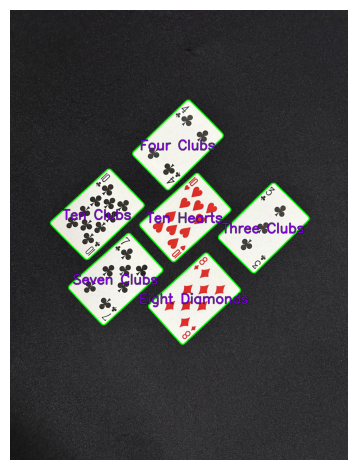

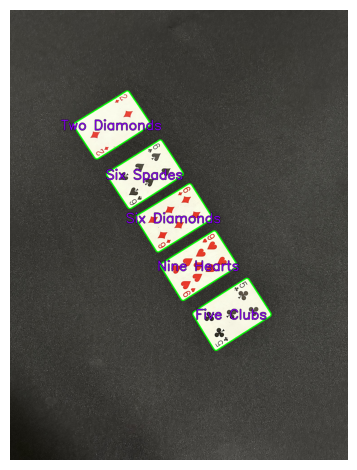

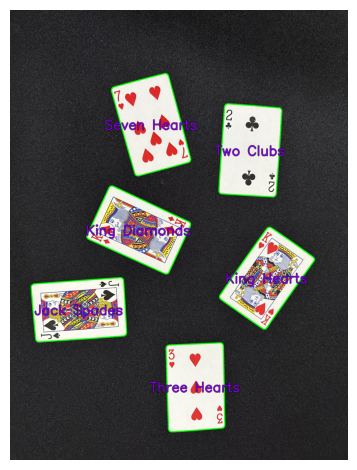

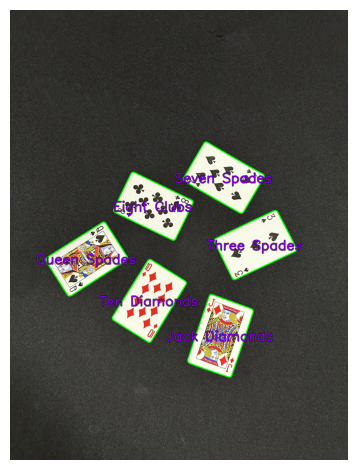

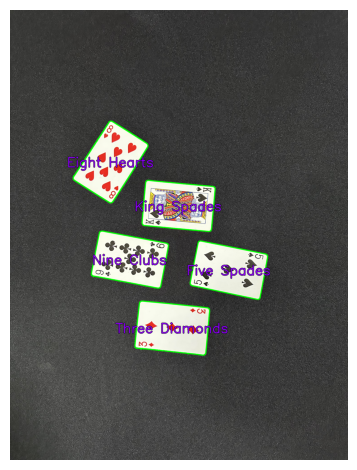

In [11]:
for i, query_path in enumerate(query_close):
    path = path_close + '/' + query_path
    detect_cards(path)

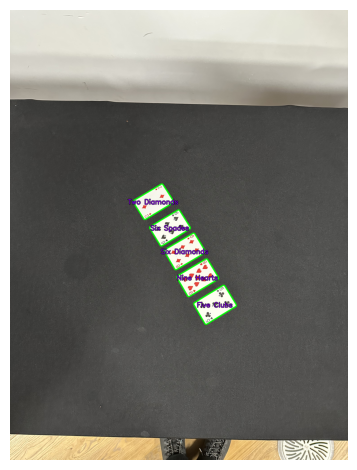

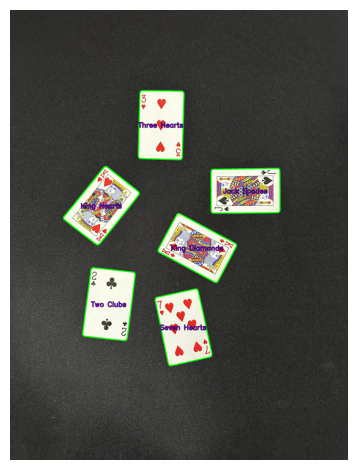

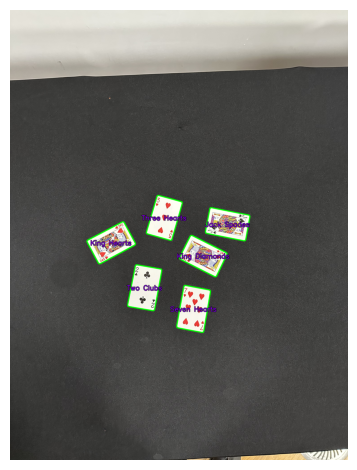

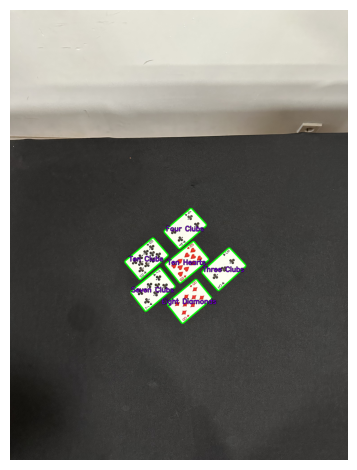

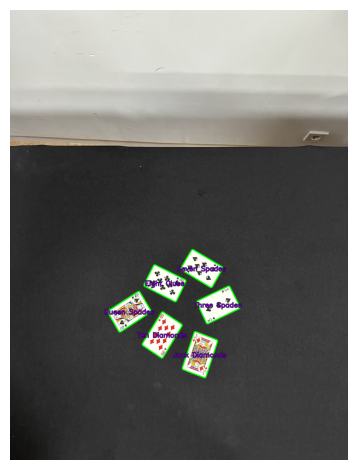

In [14]:
for i, query_path in enumerate(query_normal):
    path = path_normal + '/' + query_path
    detect_cards(path)

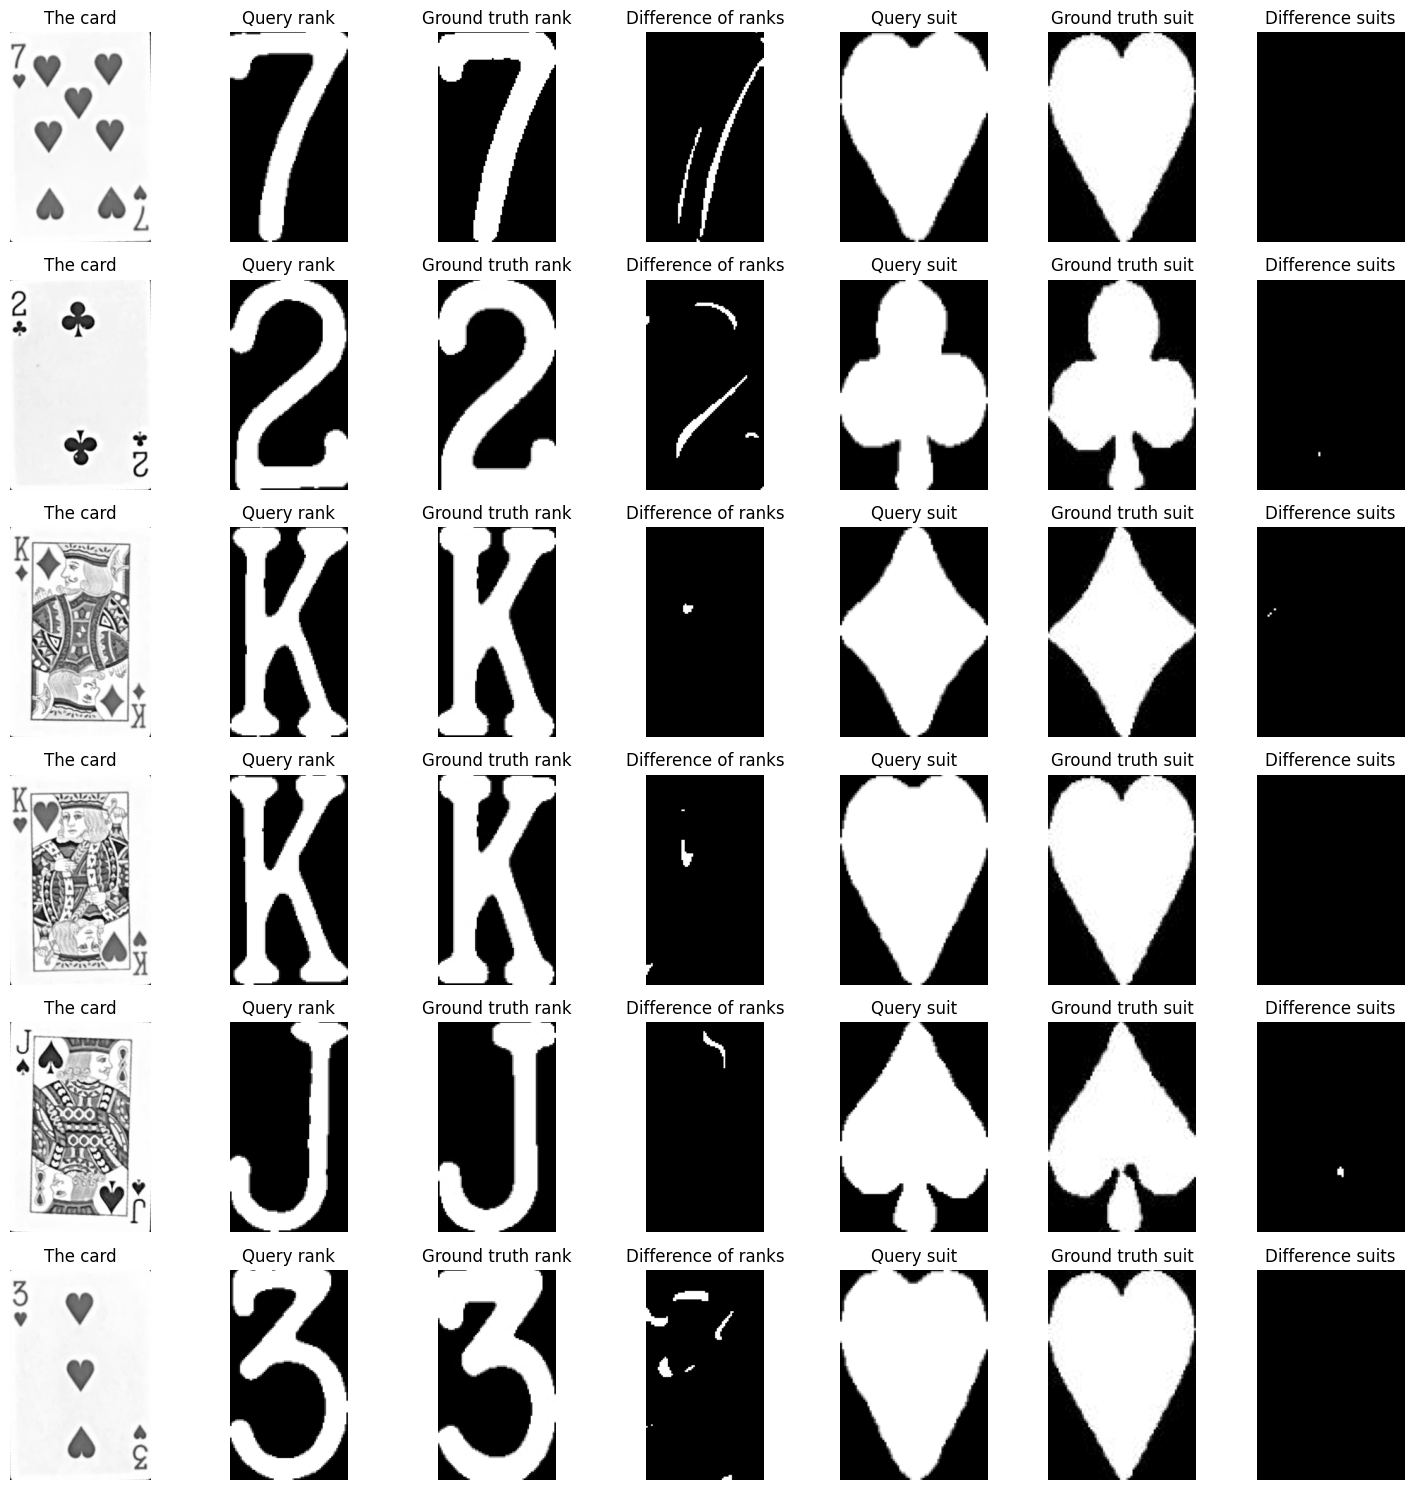

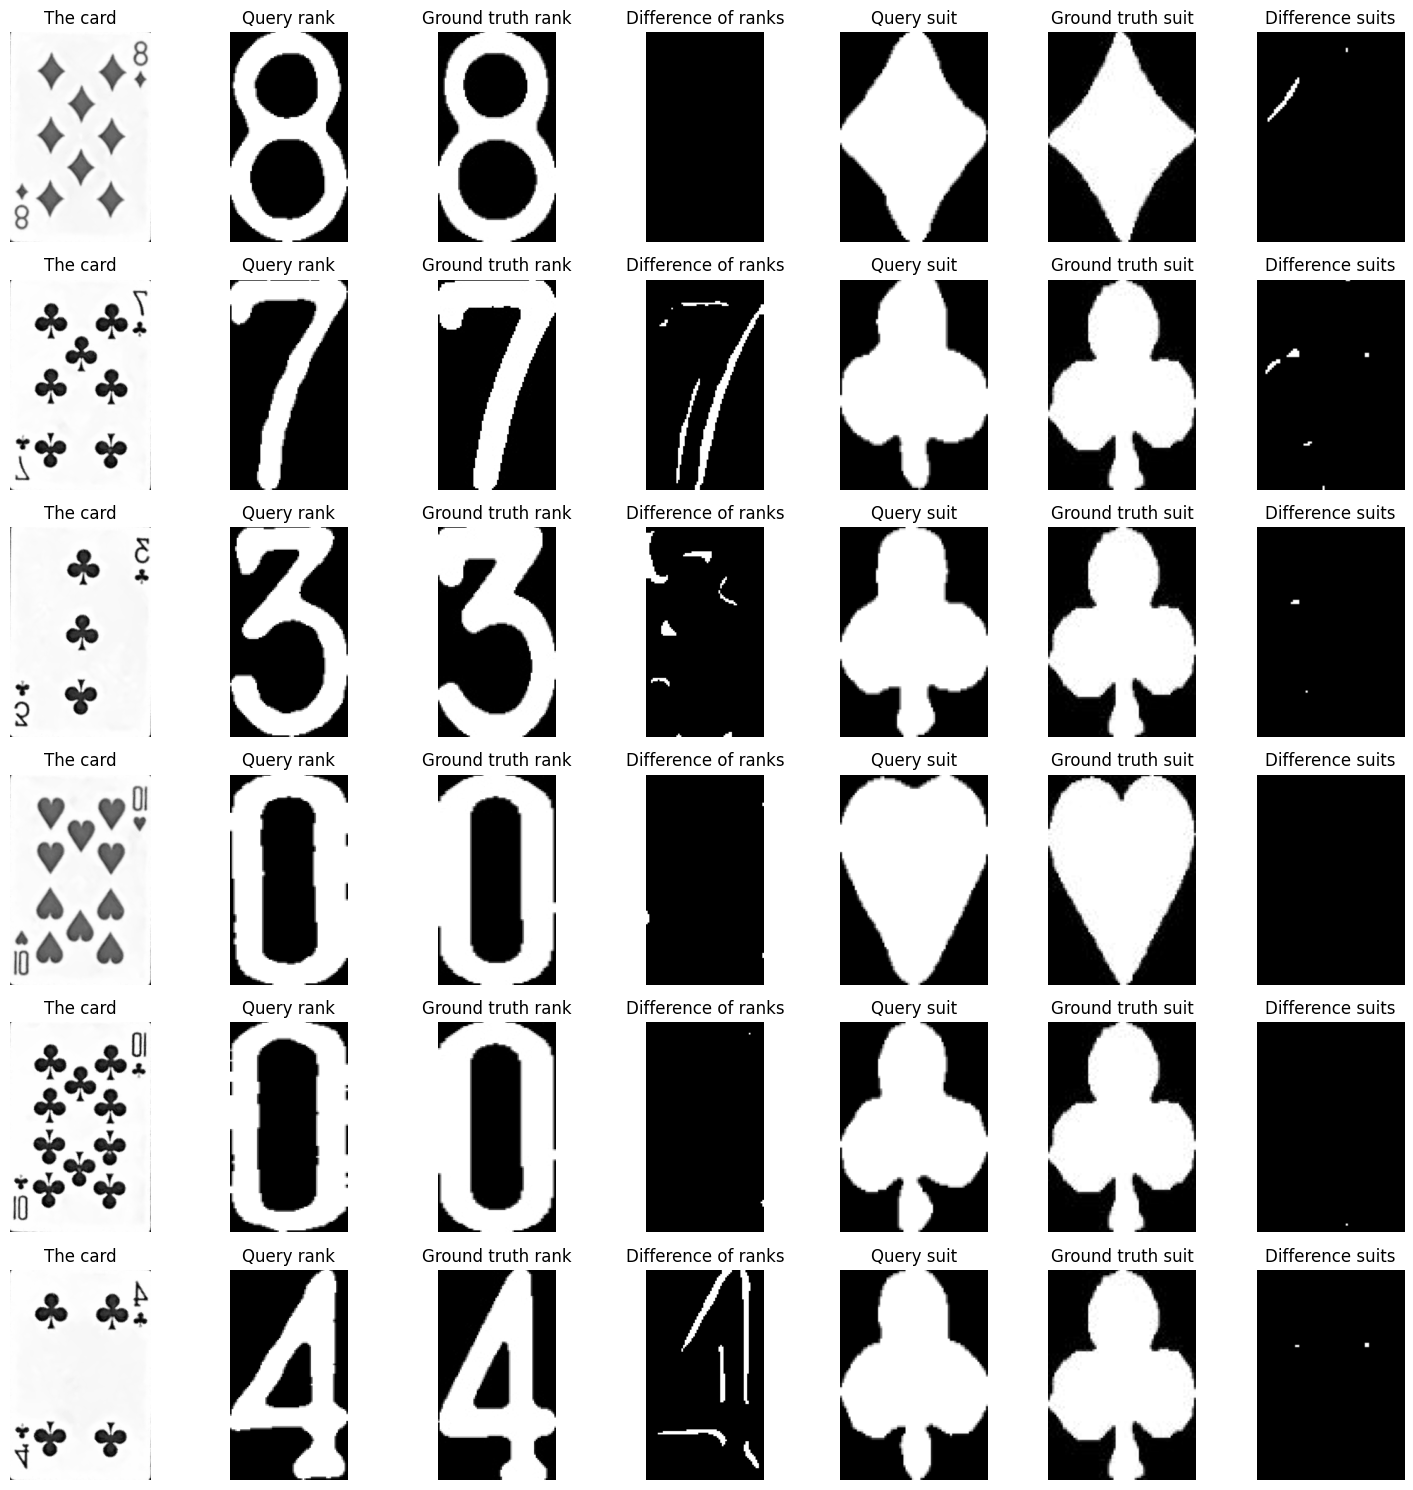

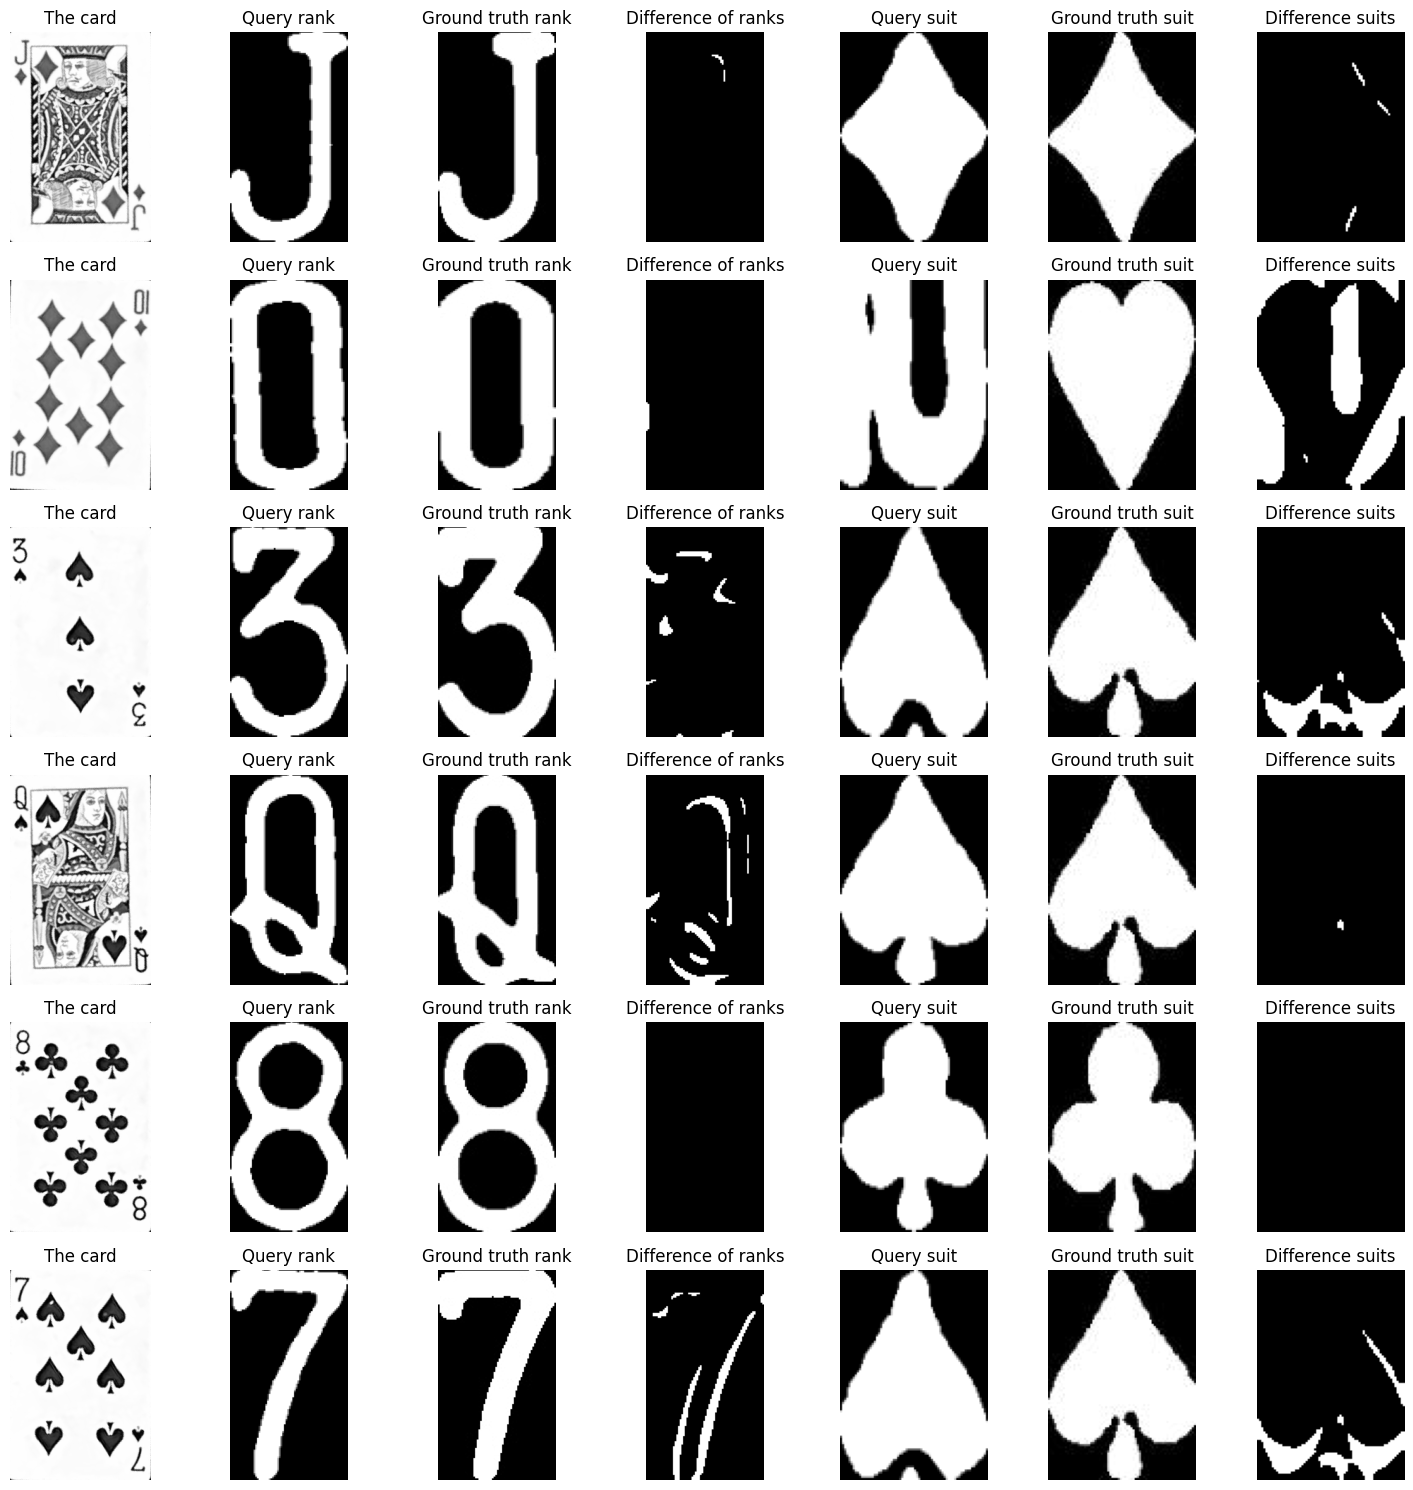

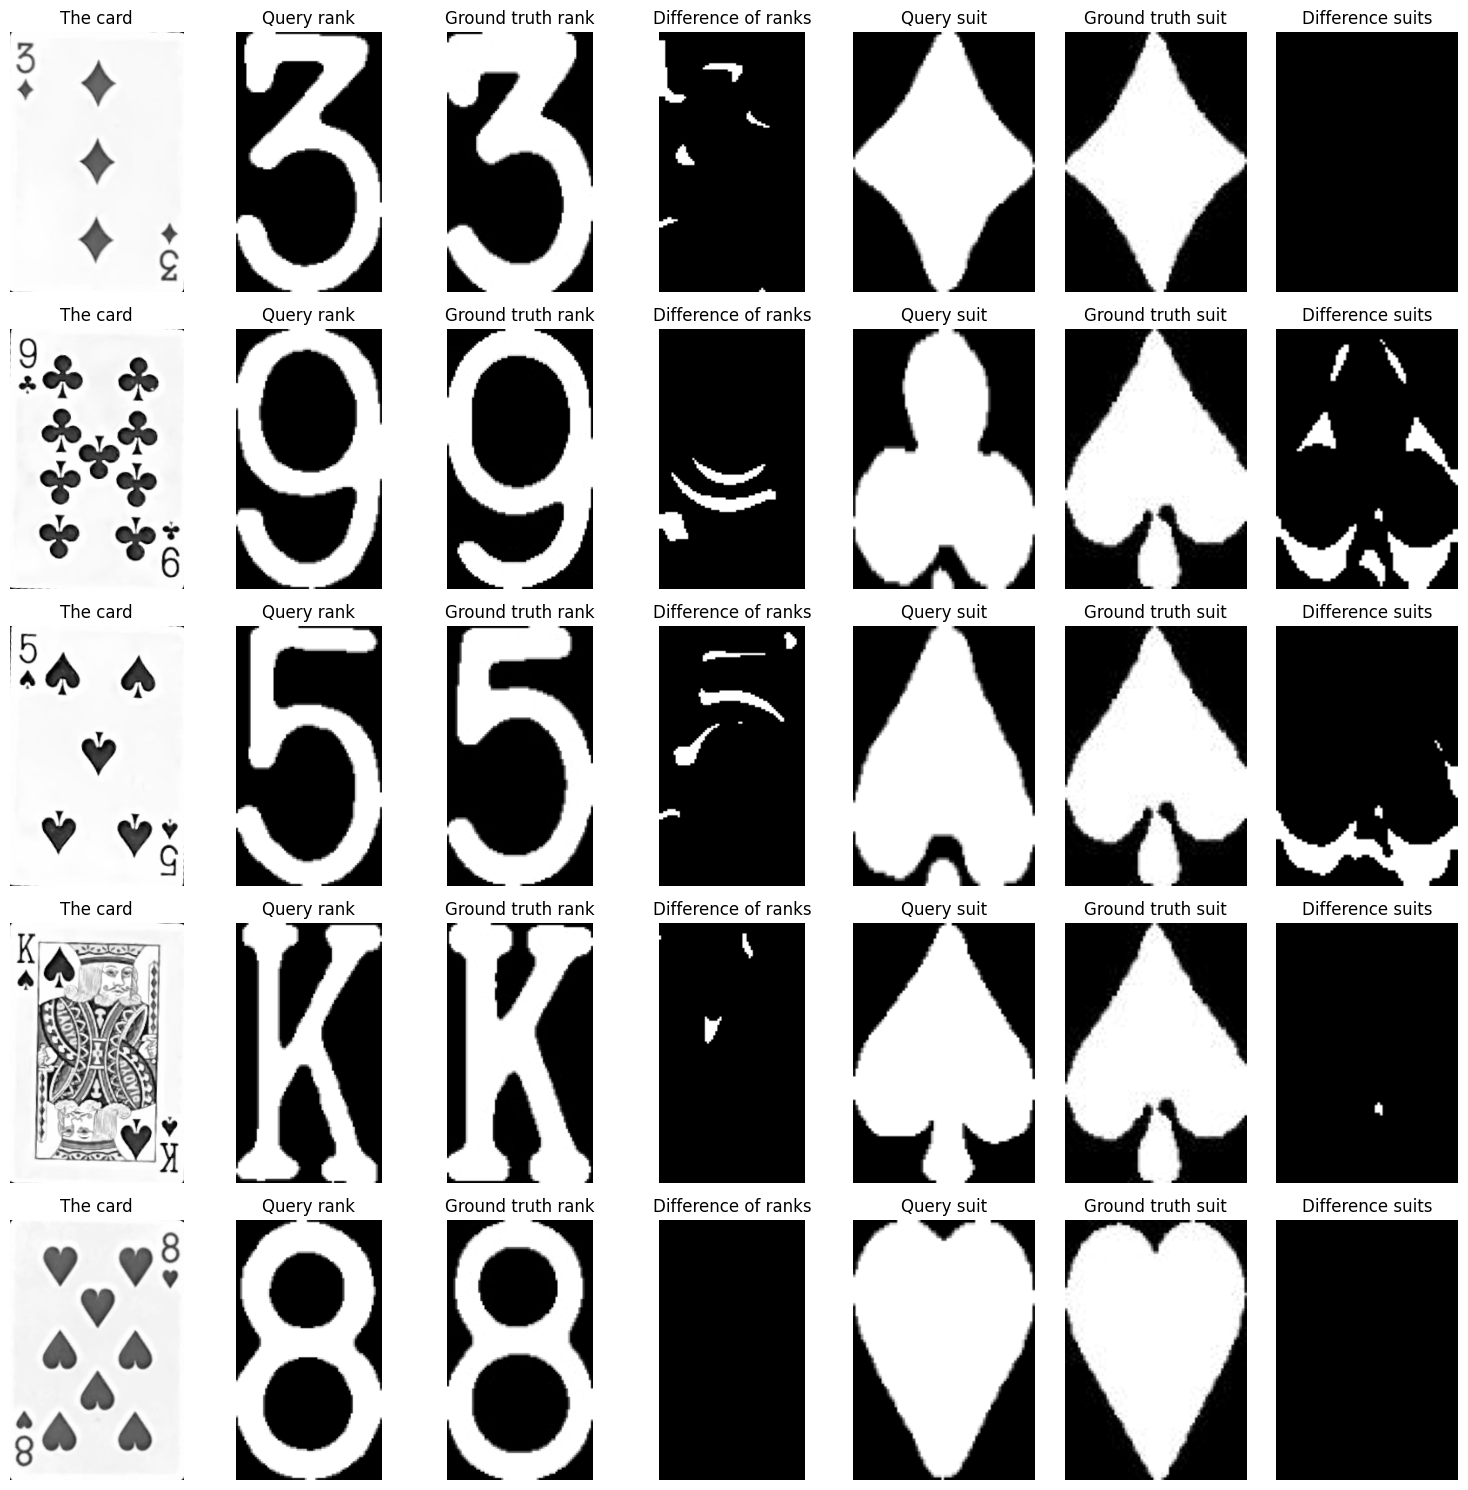

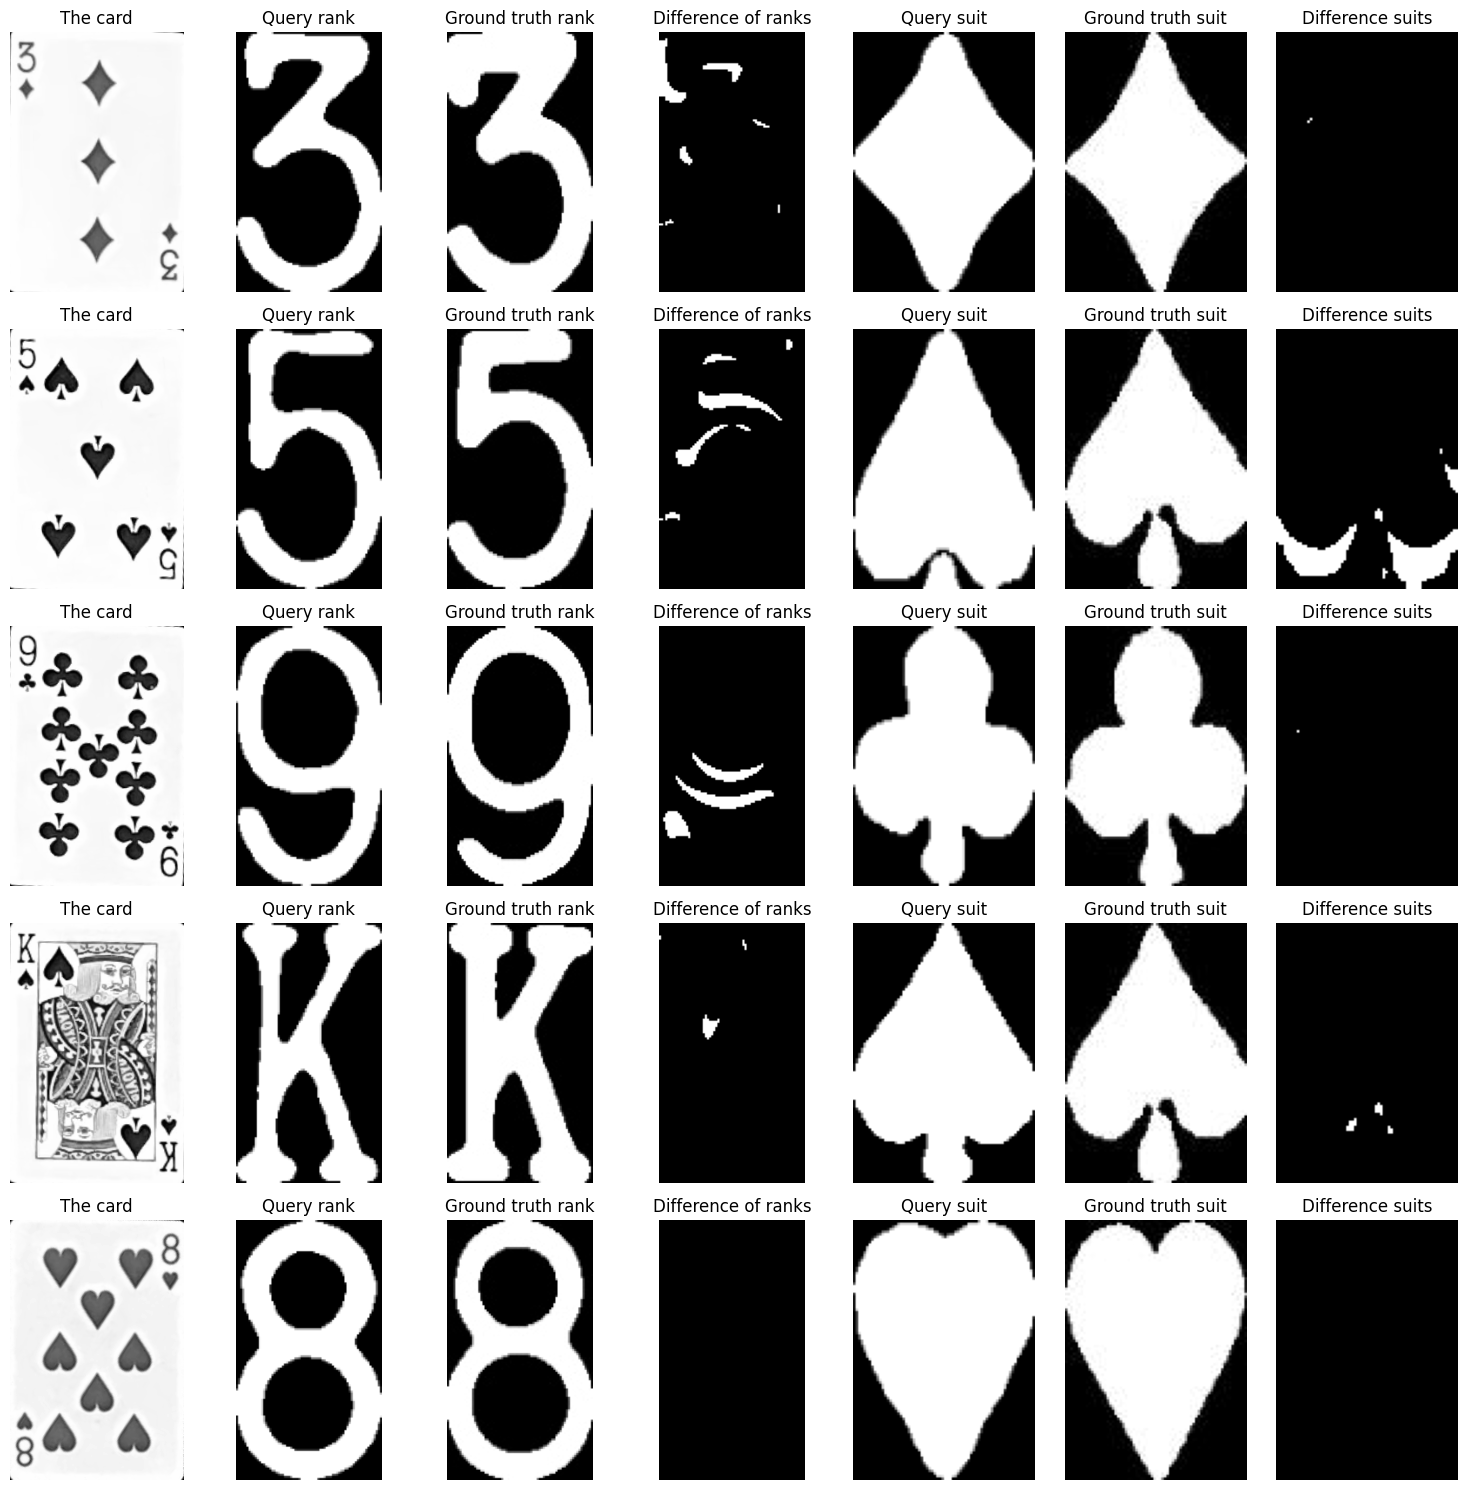

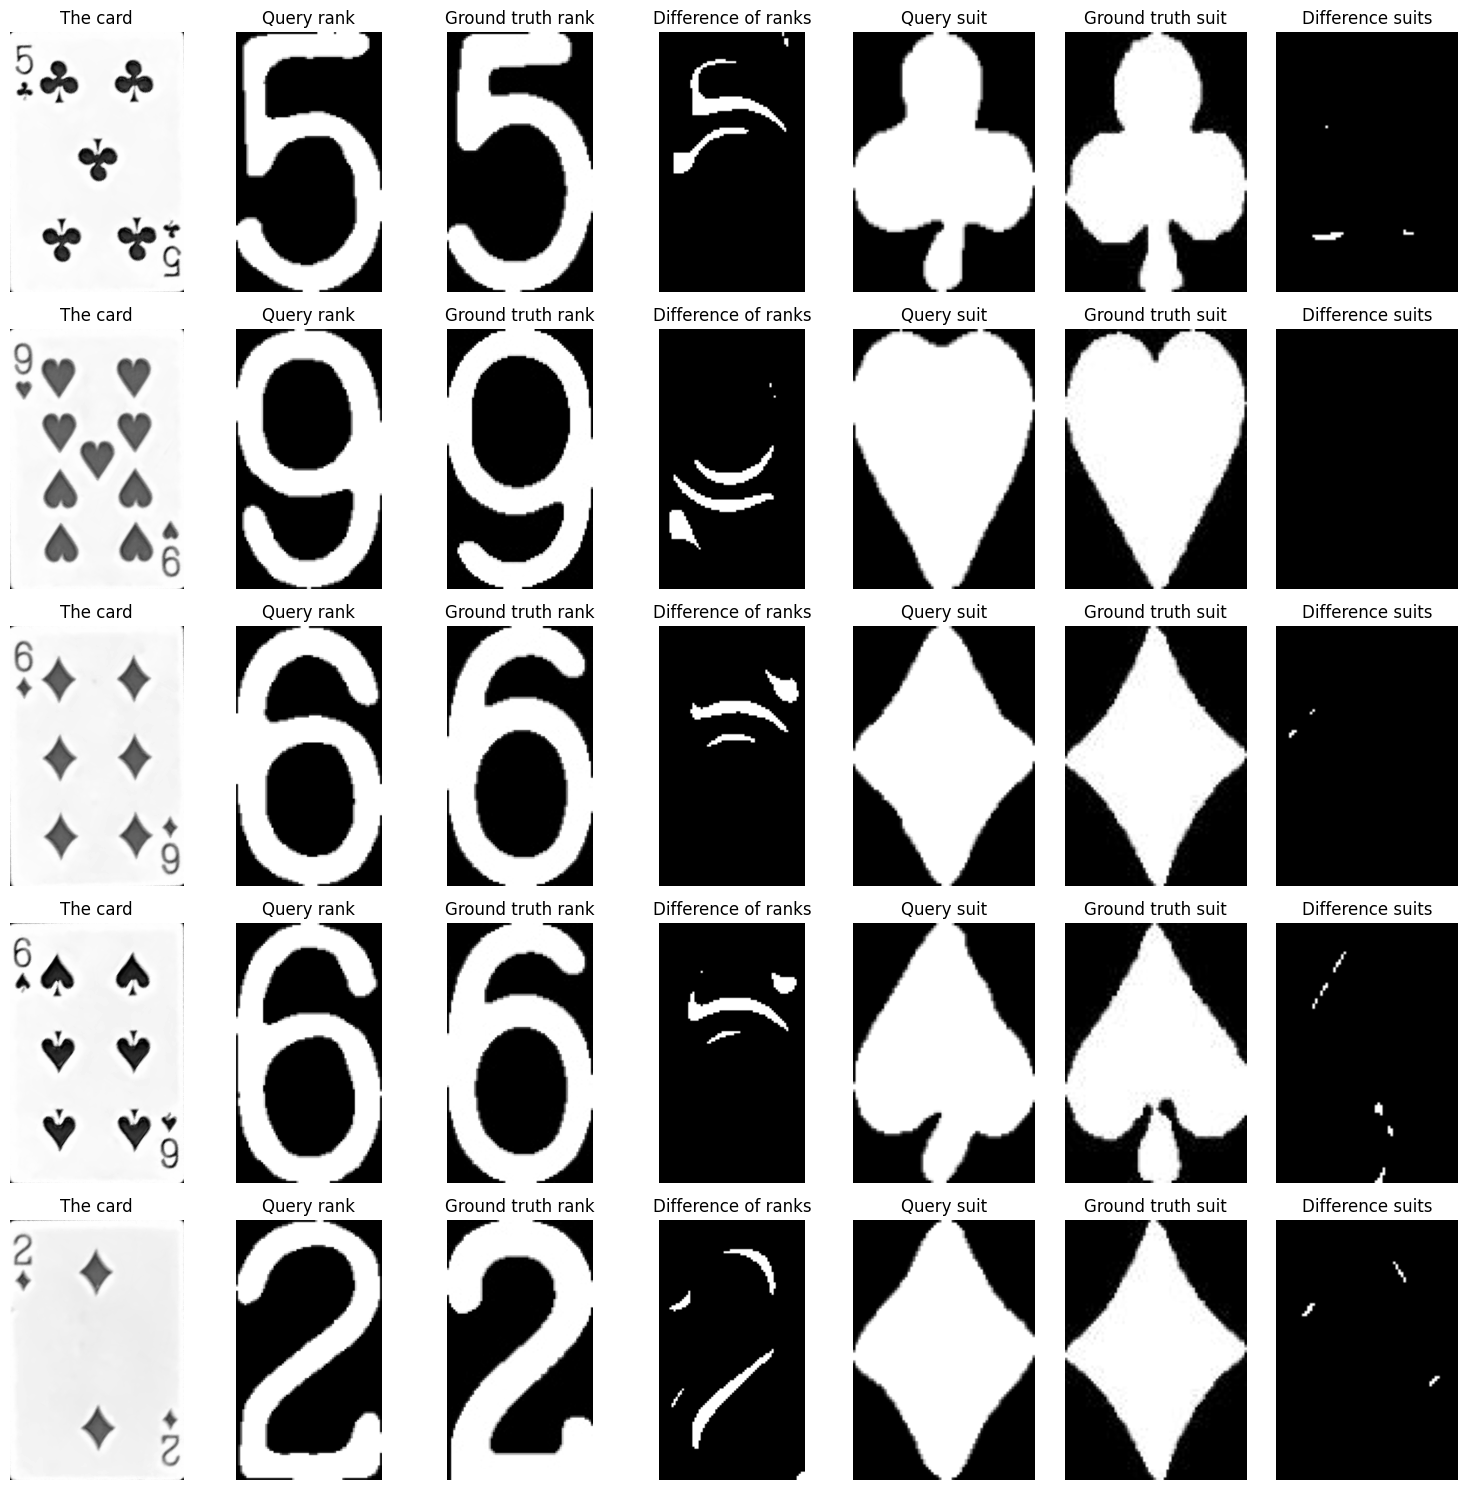

In [11]:
for i, query_path in enumerate(query_far):
    path = path_far + '/' + query_path
    detect_cards(path)